In [1]:
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in the AP and client master CSVs
ap_df = pd.read_csv('data_ap.csv')
client_df = pd.read_csv('data_client.csv')

print ap_df.columns
print client_df.columns

Index([u'BSSID', u'First time seen', u'Last time seen', u'channel', u'Speed',
       u'Privacy', u'Cipher', u'Authentication', u'Power', u'# beacons',
       u'# IV', u'LAN IP', u'ID-length', u'ESSID', u'Key'],
      dtype='object')
Index([u'Station MAC', u'First time seen', u'Last time seen', u'Power',
       u'# packets', u'BSSID', u'Probed ESSIDs'],
      dtype='object')


In [3]:
############################################
# Start with timestamp conversion and analysis.
# This is to figure out the number of seconds
# that have elapsed since the start of the experiment
# for all of the wifi data we have collected.

# Start by converting all the "First time seen" and "Last time seen" columns to Timestamps

# access points
ap_df['First time seen'] = ap_df['First time seen'].apply(pd.to_datetime)
ap_df['Last time seen']  = ap_df['Last time seen'].apply(pd.to_datetime)

# clients
client_df['First time seen'] = client_df['First time seen'].apply(pd.to_datetime)
client_df['Last time seen']  = client_df['Last time seen'].apply(pd.to_datetime)


# sort all of the "first time seen" fields and find the very, very first one.
# that timestamp will mark the start of the experiment.
times = client_df['First time seen'].append( ap_df['First time seen'] )
sorted_times = times.sort_values(inplace=False).unique()
experiment_begin = times.sort_values(inplace=False).values[0]

In [4]:
print pd.Timestamp(experiment_begin)

2016-02-27 06:10:04


In [5]:
# Make a copy of the first time seen vector,
# so we can convert it into number of seconds
# that have elapsed and insert it back into the dataframe
# (We will use this as the timestamp for each observation)
client_times = client_df['First time seen'].copy(deep=True)
client_times.name = 'Seconds Elapsed'

ap_times = ap_df['First time seen'].copy(deep=True)
ap_times.name = 'Seconds Elapsed'



print "========= Timestamp Format =============="
print client_times[0:5]
print ap_times[0:5]



# Make a vector of the time deltas 
# (The time delta is the number of seconds elapsed since 
#  the beginning of the experiment.)
client_time_deltas = client_times - experiment_begin
client_time_deltas = client_time_deltas.astype('timedelta64[s]')

ap_time_deltas = ap_times - experiment_begin
ap_time_deltas = ap_time_deltas.astype('timedelta64[s]')



print "========= Time Delta Format =============="
print client_time_deltas[0:8]
print ap_time_deltas[0:8]

========= Timestamp Format ==============
0   2016-02-27 06:10:20
1   2016-02-27 06:10:04
2   2016-02-27 06:10:20
3   2016-02-27 06:10:04
4   2016-02-27 06:10:15
Name: Seconds Elapsed, dtype: datetime64[ns]
0   2016-02-27 06:10:15
1   2016-02-27 06:10:19
2   2016-02-27 06:10:15
3   2016-02-27 06:10:15
4   2016-02-27 06:10:19
Name: Seconds Elapsed, dtype: datetime64[ns]
========= Time Delta Format ==============
0    16
1     0
2    16
3     0
4    11
5    15
6    16
7    11
Name: Seconds Elapsed, dtype: float64
0    11
1    15
2    11
3    11
4    15
5     0
6    11
7     0
Name: Seconds Elapsed, dtype: float64


In [6]:
# Since we ran a 2 hour experiment, 
# the last time delta should be 7200 s = 120 minutes = 2 hours
print client_time_deltas.sort_values(inplace=False).values[-1]

print "Bingo!"

7197.0
Bingo!


In [7]:
# Now we have a column that is number of seconds elapsed 
# since the start of the experiment.
# 
# Add that as a column to the data frame.
client_df['Seconds Elapsed'] = client_time_deltas
ap_df['Seconds Elapsed'] = ap_time_deltas


In [8]:
################################################
#
# Now let's extract a time series from the data frame
# and make our first plot.

print "-------- AP DF ----------"
print ap_df.columns
print ap_df.dtypes

print "-------- Clients DF ----------"
print client_df.columns
print client_df.dtypes


-------- AP DF ----------
Index([u'BSSID', u'First time seen', u'Last time seen', u'channel', u'Speed',
       u'Privacy', u'Cipher', u'Authentication', u'Power', u'# beacons',
       u'# IV', u'LAN IP', u'ID-length', u'ESSID', u'Key', u'Seconds Elapsed'],
      dtype='object')
BSSID                      object
First time seen    datetime64[ns]
Last time seen     datetime64[ns]
channel                     int64
Speed                       int64
Privacy                    object
Cipher                     object
Authentication             object
Power                       int64
# beacons                   int64
# IV                        int64
LAN IP                     object
ID-length                   int64
ESSID                      object
Key                       float64
Seconds Elapsed           float64
dtype: object
-------- Clients DF ----------
Index([u'Station MAC', u'First time seen', u'Last time seen', u'Power',
       u'# packets', u'BSSID', u'Probed ESSIDs', u'Seconds E

In [9]:
# list of unique macs
unique_macs = np.concatenate([  ap_df['BSSID'].unique() , client_df['Station MAC'].unique() ])

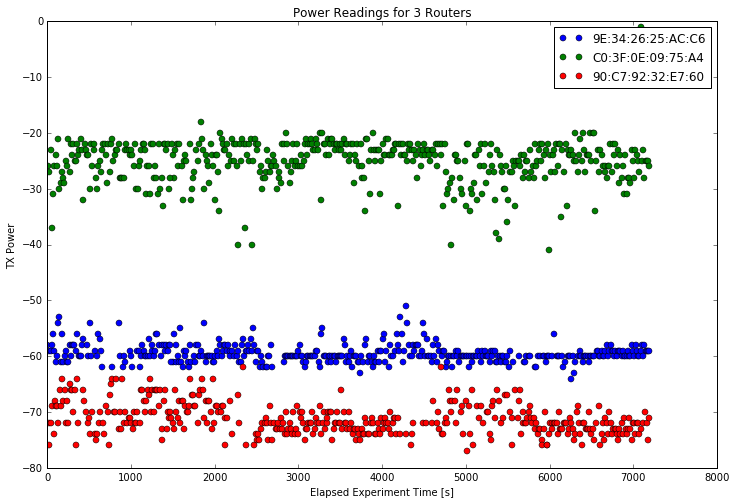

In [10]:
mac1 = unique_macs[14]
mac2 = unique_macs[36]
mac3 = unique_macs[1]
macs = [mac1,mac2,mac3]

colors=['bo','go','ro']

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for mac,cc in zip(macs,colors):
    xx = ap_df[ap_df['BSSID']==mac]['Seconds Elapsed']
    yy = ap_df[ap_df['BSSID']==mac]['Power']
    ax.plot(xx,yy,cc,label=mac)
ax.legend()
ax.set_title("Power Readings for 3 Routers")
ax.set_xlabel('Elapsed Experiment Time [s]')
ax.set_ylabel('TX Power')
plt.show()

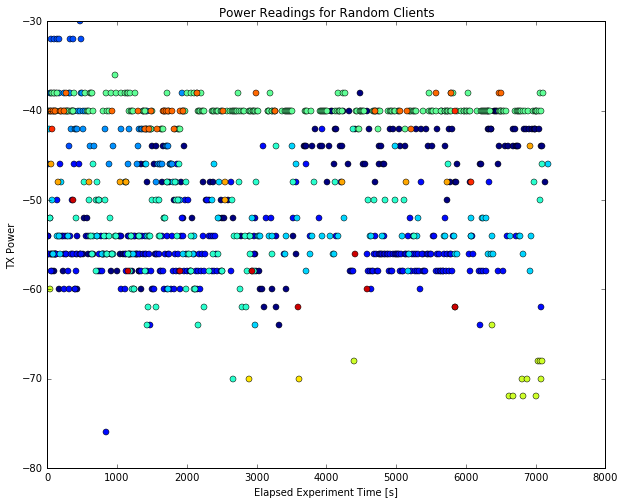

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

client_macs = client_df['Station MAC'].unique()[5:20]
color_idx = np.linspace(0, 1, len(client_macs)+1)
for i,mac in zip(color_idx,client_macs):
    xx = client_df[client_df['Station MAC']==mac]['Seconds Elapsed']
    yy = client_df[client_df['Station MAC']==mac]['Power']
    xx = xx[yy<-10]
    yy2 = yy[yy<-10]
    ax.plot(xx,yy2,'o',color=plt.cm.jet(i),label=mac)

ax.set_title("Power Readings for Random Clients")
ax.set_xlabel('Elapsed Experiment Time [s]')
ax.set_ylabel('TX Power')
plt.show()


In [12]:
# Show all the different colormaps available through Matplotlib
print dir(plt.cm)

[u'Accent', u'Accent_r', u'Blues', u'Blues_r', u'BrBG', u'BrBG_r', u'BuGn', u'BuGn_r', u'BuPu', u'BuPu_r', u'CMRmap', u'CMRmap_r', u'Dark2', u'Dark2_r', u'GnBu', u'GnBu_r', u'Greens', u'Greens_r', u'Greys', u'Greys_r', 'LUTSIZE', u'OrRd', u'OrRd_r', u'Oranges', u'Oranges_r', u'PRGn', u'PRGn_r', u'Paired', u'Paired_r', u'Pastel1', u'Pastel1_r', u'Pastel2', u'Pastel2_r', u'PiYG', u'PiYG_r', u'PuBu', u'PuBuGn', u'PuBuGn_r', u'PuBu_r', u'PuOr', u'PuOr_r', u'PuRd', u'PuRd_r', u'Purples', u'Purples_r', u'RdBu', u'RdBu_r', u'RdGy', u'RdGy_r', u'RdPu', u'RdPu_r', u'RdYlBu', u'RdYlBu_r', u'RdYlGn', u'RdYlGn_r', u'Reds', u'Reds_r', 'ScalarMappable', u'Set1', u'Set1_r', u'Set2', u'Set2_r', u'Set3', u'Set3_r', u'Spectral', u'Spectral_r', u'Wistia', u'Wistia_r', u'YlGn', u'YlGnBu', u'YlGnBu_r', u'YlGn_r', u'YlOrBr', u'YlOrBr_r', u'YlOrRd', u'YlOrRd_r', '__builtins__', '__doc__', '__file__', '__name__', '__package__', '_generate_cmap', '_reverse_cmap_spec', '_reverser', 'absolute_import', u'afmhot',